# TimesFM 2.5 with Covariates

This notebook demonstrates how to use external regressors (covariates) with TimesFM 2.5 for improved forecasting.

## Key Concepts

**Static covariates** are covariates for each time series (e.g., product category, base price)

**Dynamic covariates** are covariates for each time point (e.g., day of week, temperature, promotions)

**XReg Modes**:
- `"xreg + timesfm"`: Fit linear model on targets, then forecast residuals with TimesFM
- `"timesfm + xreg"`: Forecast with TimesFM, then fit linear model on residuals


In [1]:
import torch
import numpy as np
import timesfm
import matplotlib.pyplot as plt

torch.set_float32_matmul_precision("high")


## Load and Compile TimesFM 2.5 Model


In [2]:
model = timesfm.TimesFM_2p5_200M_torch.from_pretrained("google/timesfm-2.5-200m-pytorch")

model.compile(
    timesfm.ForecastConfig(
        max_context=512,
        max_horizon=128,
        normalize_inputs=True,
        use_continuous_quantile_head=True,
        force_flip_invariance=True,
        infer_is_positive=True,
        fix_quantile_crossing=True,
    )
)


## Example: Grocery Store Sales Forecasting

Let's forecast sales for two products (ice cream and sunscreen) with various covariates:

**Product: Ice Cream**
- Daily sales (context): [30, 30, 4, 5, 7, 8, 10]
- Category: "food" (static categorical)
- Base price: 1.99 (static numerical)
- Weekday: [0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6] (dynamic categorical)
- Has promotion: [1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0] (dynamic categorical)
- Temperature: [31.0, 24.3, 19.4, 26.2, 24.6, 30.0, 31.1, 32.4, 30.9, 26.0, 25.0, 27.8, 29.5, 31.2] (dynamic numerical)

**Product: Sunscreen**
- Daily sales (context): [5, 7, 12, 13, 5, 6, 10]
- Category: "skin product" (static categorical)
- Base price: 29.99 (static numerical)
- Weekday: same as above
- Has promotion: [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
- Temperature: same as above


In [3]:
# Prepare the data
horizon = 7  # Forecast 7 days

# Historical sales (7 days context)
ice_cream_sales = [30.0, 30.0, 4.0, 5.0, 7.0, 8.0, 10.0]
sunscreen_sales = [5.0, 7.0, 12.0, 13.0, 5.0, 6.0, 10.0]

inputs = [ice_cream_sales, sunscreen_sales]

# Static covariates
static_categorical_covariates = {
    "category": ["food", "skin_product"],
}
static_numerical_covariates = {
    "base_price": [1.99, 29.99],
}

# Dynamic covariates (7 days context + 7 days horizon = 14 values each)
dynamic_categorical_covariates = {
    "weekday": [
        [0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6],
    ],
    "has_promotion": [
        [1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
    ],
}
dynamic_numerical_covariates = {
    "temperature": [
        [31.0, 24.3, 19.4, 26.2, 24.6, 30.0, 31.1, 32.4, 30.9, 26.0, 25.0, 27.8, 29.5, 31.2],
        [31.0, 24.3, 19.4, 26.2, 24.6, 30.0, 31.1, 32.4, 30.9, 26.0, 25.0, 27.8, 29.5, 31.2],
    ],
}

print(f"Context length: {len(ice_cream_sales)} days")
print(f"Forecast horizon: {horizon} days")
print(f"Number of products: {len(inputs)}")


Context length: 7 days
Forecast horizon: 7 days
Number of products: 2


## Generate Forecasts

We'll compare three approaches:
1. **TimesFM only**: Pure time series forecast without covariates
2. **XReg + TimesFM**: Fit linear model on covariates, then forecast residuals
3. **Pure XReg**: Linear regression on covariates only (for reference)


In [4]:
# 1. Forecast with TimesFM only (no covariates)
point_forecast_only, _ = model.forecast(
    horizon=horizon,
    inputs=inputs,
)

print("TimesFM-only forecast:")
print(f"  Ice cream: {point_forecast_only[0]}")
print(f"  Sunscreen: {point_forecast_only[1]}")


TimesFM-only forecast:
  Ice cream: [13.987118 15.377063 12.501991 13.458089 14.074797 16.275576 15.717114]
  Sunscreen: [10.516831   4.9858313  6.3941565 10.211317   9.809734   3.9362676
  5.328491 ]


In [5]:
# 2. Forecast with covariates (XReg + TimesFM mode)
cov_forecast, xreg_only_forecast = model.forecast_with_covariates(
    horizon=horizon,
    inputs=inputs,
    dynamic_numerical_covariates=dynamic_numerical_covariates,
    dynamic_categorical_covariates=dynamic_categorical_covariates,
    static_numerical_covariates=static_numerical_covariates,
    static_categorical_covariates=static_categorical_covariates,
    xreg_mode="xreg + timesfm",  # Fit covariates first, then forecast residuals
    ridge=0.0,
    force_on_cpu=False,
    normalize_xreg_target_per_input=True,
)

print("\nTimesFM + Covariates forecast:")
print(f"  Ice cream: {cov_forecast[0]}")
print(f"  Sunscreen: {cov_forecast[1]}")

print("\nPure XReg forecast (for reference):")
print(f"  Ice cream: {xreg_only_forecast[0]}")
print(f"  Sunscreen: {xreg_only_forecast[1]}")



TimesFM + Covariates forecast:
  Ice cream: [-0.70478271  5.44362625  0.85552362  2.31972558 -1.46917669 -5.37000782
  0.70805117]
  Sunscreen: [13.93645552 14.05199527 12.80324344 13.80298968 12.1816942   9.9105087
 12.70998266]

Pure XReg forecast (for reference):
  Ice cream: [-0.7412253  -0.43354508 -0.8504283  -0.62052965 -1.0598562  -1.609143
 -0.8723869 ]
  Sunscreen: [1.2329484  1.5406286  1.1237456  1.353644   0.9143176  0.36503065
 1.101787  ]


## Visualize Results


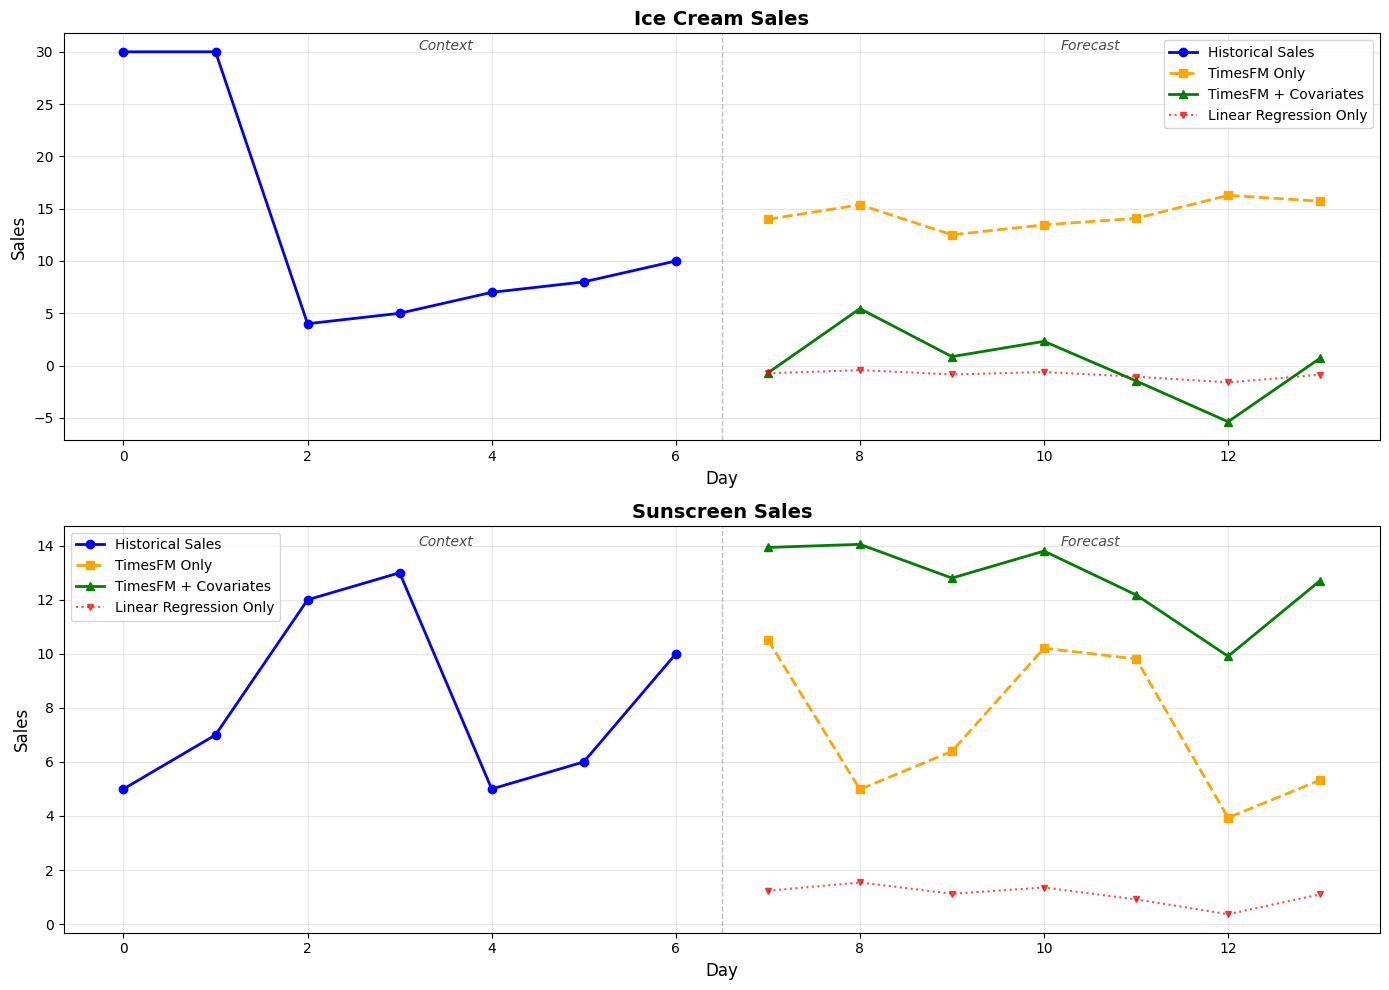

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

products = ["Ice Cream Sales", "Sunscreen Sales"]
historical_data = [ice_cream_sales, sunscreen_sales]

for idx, (ax, product_name, hist_data) in enumerate(zip(axes, products, historical_data)):
    context_len = len(hist_data)
    
    # Plot historical data
    ax.plot(range(context_len), hist_data, 'o-', label='Historical Sales', 
            color='blue', linewidth=2, markersize=6)
    
    # Plot forecasts
    forecast_range = range(context_len, context_len + horizon)
    
    ax.plot(forecast_range, point_forecast_only[idx], 's--', 
            label='TimesFM Only', color='orange', linewidth=2, markersize=6)
    
    ax.plot(forecast_range, cov_forecast[idx], '^-', 
            label='TimesFM + Covariates', color='green', linewidth=2, markersize=6)
    
    ax.plot(forecast_range, xreg_only_forecast[idx], 'v:', 
            label='Linear Regression Only', color='red', linewidth=1.5, markersize=5, alpha=0.7)
    
    # Styling
    ax.axvline(x=context_len-0.5, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    ax.set_title(f'{product_name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Day', fontsize=12)
    ax.set_ylabel('Sales', fontsize=12)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Add text annotation for context/forecast regions
    ax.text(context_len/2, ax.get_ylim()[1]*0.95, 'Context', 
            ha='center', fontsize=10, style='italic', alpha=0.7)
    ax.text(context_len + horizon/2, ax.get_ylim()[1]*0.95, 'Forecast', 
            ha='center', fontsize=10, style='italic', alpha=0.7)

plt.tight_layout()
plt.show()


## Summary

This notebook demonstrated how to use covariates with TimesFM 2.5:

1. **Static covariates**: Product category and base price (one value per time series)
2. **Dynamic covariates**: Weekday, promotions, and temperature (values for each time point)
3. **Two modes**:
   - `"xreg + timesfm"`: Fit linear model first, then forecast residuals (used above)
   - `"timesfm + xreg"`: Forecast first, then fit linear model on residuals

The combined approach (TimesFM + Covariates) leverages both:
- **TimesFM's learned patterns** from massive pre-training
- **Domain-specific knowledge** encoded in the covariates

### Requirements

To use `forecast_with_covariates`, you need:
```bash
pip install jax jaxlib scikit-learn
```

Or install with covariates support:
```bash
pip install -e ".[covariates]"
```
